## REAL TIME MACHINE LEARNING

HOMEWORK 6

Naseeruddin Lodge

801200144

In [1]:
!pip install d2l==1.0.0a1.post0
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7-py3-none-any.whl size=11093 sha256=e30d387b1d5dd078b8871f867197b8d5a215736c1a156d2e92a0834c9ceab4e7
  Stored in directory: /root/.cache/pip/wheels/b9/54/3b/f84523431ce82e08462644d279c0e13a51a00236e237e6bc7e
Successfully built ptflops


In [3]:
import ptflops
import math
import matplotlib.pyplot as plt
import torch
import time
import torchvision
import torch.nn.functional as F   
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import torchvision.models as models
from ptflops import get_model_complexity_info

torch.__version__
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'Tesla T4'

In [3]:
# Downloading the Dataset
class MTFraEng(d2l.DataModule):
    """The English-French dataset."""
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

data = MTFraEng()
raw_text = data._download()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [4]:
@d2l.add_to_class(MTFraEng)
def _preprocess(self, text):
    # Replacing non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Inserting space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)
    
text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [5]:
@d2l.add_to_class(MTFraEng) 
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>']])

In [7]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module): 
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [8]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(d2l.Encoder): 
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [9]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

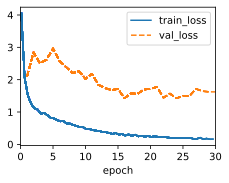

In [10]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [11]:
print("Training Time: ", t1-t0)

Training Time:  37.30612325668335


In [12]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


##Problem 1


For the problem of Machine Translation problem: Train a deeper Transformer than what we did during the lectures.  How does it affect the training speed, model complexity, and translation performance both quantitatively and qualitatively? Report and plot your results.

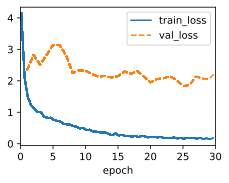

In [16]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 3, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [17]:
print("Training Time with 3 Blocks): ", t1-t0)

Training Time with 3 Blocks):  33.06752061843872


In [18]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


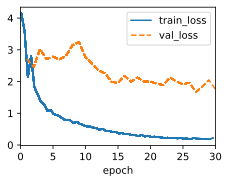

In [19]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 6, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [20]:
print("Training Time with 6 Blocks): ", t1-t0)

Training Time with 6 Blocks):  44.83120656013489


In [21]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['vas-y', '.'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'suis', 'calme', '.'], bleu,0.537
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


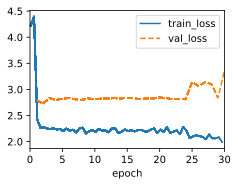

In [22]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 9, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [23]:
print("Training Time with 9 Blocks): ", t1-t0)

Training Time with 9 Blocks):  43.431763648986816


In [24]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000
i lost . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000
he's calm . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000
i'm home . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000


In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [5]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))
        
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [6]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

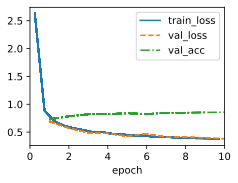

In [7]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [8]:
print("Training Time: ", t1 - t0)

Training Time:  330.15335273742676


In [9]:
input_shape = (1, img_size, img_size)
flops, params = get_model_complexity_info(model, input_shape, as_strings=True, print_per_layer_stat=True)

print(f"Number of FLOPs: {flops}")
print(f"Number of parameters: {params}")

ViT(
  6.44 M, 99.699% Params, 237.76 MMac, 100.000% MACs, 
  (patch_embedding): PatchEmbedding(
    131.58 k, 2.038% Params, 4.74 MMac, 1.992% MACs, 
    (conv): Conv2d(131.58 k, 2.038% Params, 4.74 MMac, 1.992% MACs, 1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (blks): Sequential(
    6.3 M, 97.566% Params, 233.02 MMac, 98.005% MACs, 
    (0): ViTBlock(
      3.15 M, 48.783% Params, 116.51 MMac, 49.003% MACs, 
      (ln1): LayerNorm(1.02 k, 0.016% Params, 18.94 KMac, 0.008% MACs, (512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        1.05 M, 16.237% Params, 38.8 MMac, 16.318% MACs, 
        (attention): DotProductAttention(
          0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
          (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
        )
        (W_q): Linear(262.14 k, 4.059% Params, 9.7 MMac, 4.079% MACs, in_features=512, 

## Problem 2

For the problem of the Vision Transformer, we need, in lectures, to train a deeper Transformer with more multiheaded self-attention blocks.   How does it affect the training speed, model complexity, and validation accuracy? Report and plot your results.

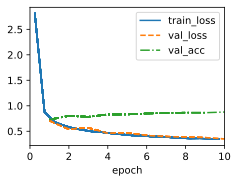

In [10]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 16, 4
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [11]:
print("Training Time with 4 Blocks): ", t1 - t0)

Training Time with 4 Blocks):  588.8874027729034


In [12]:
input_shape = (1, img_size, img_size)
flops, params = get_model_complexity_info(model, input_shape, as_strings=True, print_per_layer_stat=True)

print(f"Number of FLOPs: {flops}")
print(f"Number of parameters: {params}")

ViT(
  12.74 M, 99.848% Params, 470.78 MMac, 100.000% MACs, 
  (patch_embedding): PatchEmbedding(
    131.58 k, 1.031% Params, 4.74 MMac, 1.006% MACs, 
    (conv): Conv2d(131.58 k, 1.031% Params, 4.74 MMac, 1.006% MACs, 1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (blks): Sequential(
    12.6 M, 98.768% Params, 466.03 MMac, 98.993% MACs, 
    (0): ViTBlock(
      3.15 M, 24.692% Params, 116.51 MMac, 24.748% MACs, 
      (ln1): LayerNorm(1.02 k, 0.008% Params, 18.94 KMac, 0.004% MACs, (512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        1.05 M, 8.219% Params, 38.8 MMac, 8.241% MACs, 
        (attention): DotProductAttention(
          0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
          (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
        )
        (W_q): Linear(262.14 k, 2.055% Params, 9.7 MMac, 2.060% MACs, in_features=512, 

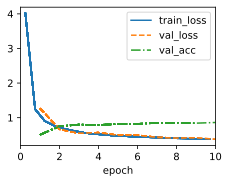

In [13]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 16, 8
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [14]:
# Calculating the Training Speed
print("Training Time with 8 Blocks): ", t1 - t0)

Training Time with 8 Blocks):  1130.6072235107422


In [15]:
input_shape = (1, img_size, img_size) 
flops, params = get_model_complexity_info(model, input_shape, as_strings=True, print_per_layer_stat=True)

print(f"Number of FLOPs: {flops}")
print(f"Number of parameters: {params}")

ViT(
  25.34 M, 99.923% Params, 936.81 MMac, 100.000% MACs, 
  (patch_embedding): PatchEmbedding(
    131.58 k, 0.519% Params, 4.74 MMac, 0.506% MACs, 
    (conv): Conv2d(131.58 k, 0.519% Params, 4.74 MMac, 0.506% MACs, 1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (blks): Sequential(
    25.2 M, 99.380% Params, 932.07 MMac, 99.494% MACs, 
    (0): ViTBlock(
      3.15 M, 12.423% Params, 116.51 MMac, 12.437% MACs, 
      (ln1): LayerNorm(1.02 k, 0.004% Params, 18.94 KMac, 0.002% MACs, (512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        1.05 M, 4.135% Params, 38.8 MMac, 4.141% MACs, 
        (attention): DotProductAttention(
          0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
          (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
        )
        (W_q): Linear(262.14 k, 1.034% Params, 9.7 MMac, 1.035% MACs, in_features=512, 